In [35]:
# Install (if needed) and Imports
# Uncomment the next line if your environment is missing any of these libraries.
# !pip install pandas matplotlib annoy sentence-transformers scikit-learn lxml beautifulsoup4

import re
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from itertools import combinations
from annoy import AnnoyIndex
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

In [33]:
################################################################################
# STEP 0: Helper Methods & Parameters
# - Cleans text
# - Parses labelled_duplicates
# - Converts angular distance to cos_sim
# - Builds feature vectors for logistic regression
################################################################################

def clean_text(text):
    """Remove HTML tags and extra whitespace."""
    if not isinstance(text, str):
        return ""
    text_no_html = BeautifulSoup(text, "lxml").get_text()
    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    text_no_html = re.sub(r"\s+", " ", text_no_html).strip()
    return text_no_html

def parse_label_list(label_str):
    """
    Parse a label string into a list of integer IDs.

    e.g., "['123','456']" or "['123' '456']" => [123, 456].
    Returns an empty list if parsing fails or the string is invalid.
    """
    if not isinstance(label_str, str):
        return []
    matches = re.findall(r"'(\d+)'", label_str)
    return [int(m) for m in matches]

def angular_to_cos_sim(distance):
    """
    Annoy uses angular distance = 2 * (1 - cos_sim).
    => cos_sim = 1 - (distance / 2)
    """
    return 1.0 - (distance / 2.0)

def build_features_for_pair(idA, idB, embeddings, id_to_idx):
    """Combine embeddings of idA and idB into a single feature vector."""
    iA = id_to_idx[idA]
    iB = id_to_idx[idB]
    eA = embeddings[iA]
    eB = embeddings[iB]
    diff = np.abs(eA - eB)
    mult = eA * eB
    return np.concatenate([eA, eB, diff, mult])

DATA_FILE = "./dataset.csv"  
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# NEGATIVE_RATIO: 
# The ratio of positive to negative pairs in the training set. 
# For example, 1.0 means a 1:1 ratio between positive and negative samples.

NEGATIVE_RATIO = 1.0

# TEST_SIZE: 
# The fraction of data held out for testing. 
# A common practice is an 80/20 split (test_size=0.2).

TEST_SIZE = 0.2

# RANDOM_SEED:
# A fixed seed for random operations, ensuring consistent results across runs.

RANDOM_SEED = 42

# SIMILARITY_THRESHOLD:
# If non-duplicate pairs exceed this similarity, they're considered "hard negatives." 
# For example, 0.90 means non-duplicates with ≥90% similarity are challenging examples.

SIMILARITY_THRESHOLD = 0.90

# NEIGHBORS:
# How many nearest neighbors Annoy should return for each query. 
# More neighbors can find more potential duplicates (or near-duplicates).

NEIGHBORS = 5

# NUM_TREES:
# Number of random-projection trees in the Annoy index. 
# More trees increases recall but also slows down index building.

NUM_TREES = 20

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"DATA_FILE={DATA_FILE}, MODEL_NAME={MODEL_NAME}, NEGATIVE_RATIO={NEGATIVE_RATIO}, "
      f"TEST_SIZE={TEST_SIZE}, SIMILARITY_THRESHOLD={SIMILARITY_THRESHOLD}, "
      f"NEIGHBORS={NEIGHBORS}, NUM_TREES={NUM_TREES}")

DATA_FILE=./dataset.csv, MODEL_NAME=sentence-transformers/all-MiniLM-L6-v2, NEGATIVE_RATIO=1.0, TEST_SIZE=0.2, SIMILARITY_THRESHOLD=0.9, NEIGHBORS=5, NUM_TREES=20


In [37]:
################################################################################
# STEP 1: Load & Clean Data
# - Read the CSV
# - Fill missing titles/abstracts and apply text cleaning
# - Combine processed_title and processed_abstract into a single 'combined_text' field
################################################################################

df = pd.read_csv(DATA_FILE)
df["processed_title"] = df["processed_title"].fillna("").apply(clean_text)
df["processed_abstract"] = df["processed_abstract"].fillna("").apply(clean_text)
df["combined_text"] = df["processed_title"] + " " + df["processed_abstract"]

df.head(3)

,core_id,doi,original_abstract,original_title,processed_title,processed_abstract,cat,labelled_duplicates,combined_text
0,11251086,10.1016/j.ajhg.2007.12.013,Unobstructed vision requires a particular refr...,Mutation of solute carrier SLC16A12 associates...,mutation of solute carrier slc16a12 associates...,unobstructed vision refractive lens differenti...,exact_dup,['82332306'],mutation of solute carrier slc16a12 associates...
1,11309751,10.1103/PhysRevLett.101.193002,Two-color multiphoton ionization of atomic hel...,Polarization control in two-color above-thresh...,polarization control in two-color above-thresh...,multiphoton ionization helium combining extrem...,exact_dup,['147599753'],polarization control in two-color above-thresh...
2,11311385,10.1016/j.ab.2011.02.013,Lectin’s are proteins capable of recognising a...,Optimisation of the enzyme-linked lectin assay...,optimisation of the enzyme-linked lectin assay...,lectin’s capable recognising oligosaccharide t...,exact_dup,['147603441'],optimisation of the enzyme-linked lectin assay...


In [38]:
################################################################################
# STEP 2: Build ID Mappings & Positive Pairs from Clusters
# - Create a dictionary { core_id -> row_index } for O(1) lookups
# - Generate all pairwise duplicates from multi-document clusters
#   (e.g., [123, 456, 789] => (123, 456), (123, 789), (456, 789))
################################################################################

# doc ID -> row index
id_to_idx = {}
idx_to_id = {}

for i, row in df.iterrows():
    cid = row["core_id"]
    id_to_idx[cid] = i
    idx_to_id[i] = cid

# Multi-document clusters => all pairwise combos
# Example: if row references [123, 456, 789], we form (123,456), (123,789), (456,789).
positive_pairs = set()

for _, row in df.iterrows():
    main_id = row["core_id"]
    cluster_ids = [main_id] + parse_label_list(row["labelled_duplicates"])
    cluster_ids = [cid for cid in cluster_ids if cid in id_to_idx]
    cluster_ids = sorted(set(cluster_ids))
    for (a, b) in combinations(cluster_ids, 2):
        positive_pairs.add((a, b))

positive_pairs = list(positive_pairs)
pos_set = set(positive_pairs)
print(f"Total positive (duplicate) pairs from clusters: {len(positive_pairs)}")

Total positive (duplicate) pairs from clusters: 38630


In [39]:
################################################################################
# STEP 3: Embed Documents & Create Annoy Index
# - Convert combined_text into embeddings (vector representations)
# - Build an Annoy index (using metric="angular") for approximate nearest neighbors
# - NUM_TREES controls how thoroughly the index is built
################################################################################

print(f"Loading model: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME)
combined_texts = df["combined_text"].tolist()
embeddings = model.encode(combined_texts, batch_size=32, show_progress_bar=True)
embeddings = embeddings.astype("float32")

emb_dim = embeddings.shape[1]
print(f"Embeddings shape: {embeddings.shape}")

annoy_index = AnnoyIndex(emb_dim, metric="angular")
for i in range(len(embeddings)):
    annoy_index.add_item(i, embeddings[i])

annoy_index.build(NUM_TREES)
print(f"Annoy index built with {NUM_TREES} trees for dimension={emb_dim}")

Loading model: sentence-transformers/all-MiniLM-L6-v2


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

Embeddings shape: (100000, 384)
Annoy index built with 20 trees for dimension=384


In [67]:
################################################################################
# STEP 4: Random Negative Samples for Training Classifier
# - Randomly sample non-duplicate pairs as baseline negative examples
# - The total number of negatives is proportional to NEGATIVE_RATIO
################################################################################

all_ids = list(id_to_idx.keys())
num_neg = int(len(positive_pairs) * NEGATIVE_RATIO)
random_negatives = set()

while len(random_negatives) < num_neg:
    idA, idB = random.sample(all_ids, 2)
    pair = tuple(sorted([idA, idB]))
    # Ensure it's not a known duplicate
    if pair not in pos_set:
        random_negatives.add(pair)

print(f"Random negatives: {len(random_negatives)}")

Random negatives: 38630


In [68]:
################################################################################
# STEP 5: Hard Negative Mining for Near-Duplicate Non-duplicates
# - For each document, retrieve its top-K neighbors (NEIGHBORS) from Annoy
# - If similarity >= SIMILARITY_THRESHOLD and not labeled duplicates => 'hard negative'
# - These highly similar but unlabeled examples add complexity for the classifier
################################################################################

hard_negatives = set()

for i in range(len(embeddings)):
    neighbors, distances = annoy_index.get_nns_by_item(i, NEIGHBORS, include_distances=True)
    main_doc_id = idx_to_id[i]
    for j, dist in zip(neighbors, distances):
        if j == i:
            continue
        cos_sim = angular_to_cos_sim(dist)
        if cos_sim >= SIMILARITY_THRESHOLD:
            neighbor_doc_id = idx_to_id[j]
            pair = tuple(sorted([main_doc_id, neighbor_doc_id]))
            if pair not in pos_set:
                hard_negatives.add(pair)

print(f"Hard negatives found: {len(hard_negatives)} using similarity threshold={SIMILARITY_THRESHOLD}")

Hard negatives found: 318 using similarity threshold=0.9


In [44]:
################################################################################
# STEP 6: Finalize Training Dataset
# - Combine positive pairs with both random & hard negatives
# - Shuffle them into a single list of labeled pairs (1 for duplicates, 0 for not)
################################################################################

combined_negatives = random_negatives.union(hard_negatives)
pairs_labeled = [(p[0], p[1], 1) for p in positive_pairs] + \
                [(p[0], p[1], 0) for p in combined_negatives]
random.shuffle(pairs_labeled)

print(f"Total labeled pairs: {len(pairs_labeled)}")

Total labeled pairs: 77578


In [62]:
################################################################################
# STEP 7: Build Feature Matrix, Train/Test Split, and Track Predictions
# - Convert all (idA, idB) pairs into a DataFrame (pairs_df)
# - Build feature vectors (X) and labels (y) from pairs_df
# - Use an index array (pairs_index) so we know which row maps to which pair
# - Train the model, predict on test set, and store predictions in pairs_test
################################################################################

# 7a) Convert final labeled pairs into a DataFrame
pairs_df = pd.DataFrame(pairs_labeled, columns=["idA", "idB", "label"])

# 7b) Build the feature matrix (X) and label vector (y)
X_list = []
for row in pairs_df.itertuples(index=True):
    feats = build_features_for_pair(row.idA, row.idB, embeddings, id_to_idx)
    X_list.append(feats)

X = np.array(X_list, dtype=np.float32)
y = pairs_df["label"].values.astype(np.int32)

print(f"Feature matrix shape: {X.shape}, label shape: {y.shape}")

# 7c) Keep track of row indices so we can map predictions back to doc pairs
pairs_index = np.arange(len(X))

# 7d) Train/Test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, pairs_index,
    test_size=TEST_SIZE, stratify=y, random_state=RANDOM_SEED
)
print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")

# 7e) Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 7f) Predict on test set
y_pred = clf.predict(X_test)

# 7g) Attach predictions back to pairs
pairs_test = pairs_df.iloc[idx_test].copy()
pairs_test["pred_label"] = y_pred

# Now pairs_test has columns: ["idA","idB","label","pred_label"]
# You can see exactly which documents the model flagged as duplicates
print("\nSample predicted rows:")
display(pairs_test.head(5))

Feature matrix shape: (77578, 1536), label shape: (77578,)
Train size: 62062, Test size: 15516

Sample predicted rows:


,idA,idB,label,pred_label
38128,84332946,188176942,0,0
54802,53748197,144256324,1,1
21950,52677575,52716915,1,1
41315,48182725,52884690,0,0
55648,42123830,42924881,1,1


In [63]:
################################################################################
# STEP 8: Basic Evaluation at Default Threshold
# - Uses predict(X_test), which applies a default 0.5 threshold
# - Prints standard precision, recall, F1
################################################################################

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print("====================================")
print("Evaluation on test set (default threshold=0.5):")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 score:  {f1:.4f}")
print("====================================")

Evaluation on test set (default threshold=0.5):
Precision: 0.9884
Recall:    0.9720
F1 score:  0.9802


Threshold  Precision  Recall  F1
    0.00      0.498   1.000  0.665
    0.05      0.878   0.997  0.934
    0.10      0.943   0.995  0.968
    0.15      0.965   0.992  0.978
    0.20      0.973   0.989  0.981
    0.25      0.978   0.986  0.982
    0.30      0.982   0.983  0.983
    0.35      0.984   0.980  0.982
    0.40      0.986   0.978  0.982
    0.45      0.987   0.975  0.981
    0.50      0.988   0.972  0.980
    0.55      0.989   0.969  0.979
    0.60      0.990   0.966  0.978
    0.65      0.990   0.963  0.976
    0.70      0.990   0.959  0.974
    0.75      0.990   0.956  0.973
    0.80      0.990   0.951  0.970
    0.85      0.990   0.946  0.967
    0.90      0.990   0.933  0.961
    0.95      0.990   0.907  0.947
    1.00      0.000   0.000  0.000


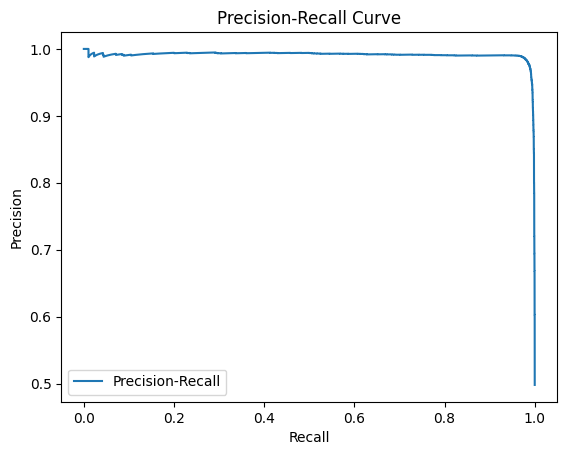

In [64]:
################################################################################
# STEP 9: Threshold Tuning & Precision-Recall Curve
# - Convert model outputs to probabilities
# - Sweep thresholds from 0.0 to 1.0 and print precision, recall, F1
# - Plot Precision-Recall curve to visualize trade-offs
################################################################################

y_proba = clf.predict_proba(X_test)[:, 1]

import numpy as np
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
import matplotlib.pyplot as plt

# 9a) Enumerate thresholds in increments of 0.05
thresholds = np.linspace(0.0, 1.0, 21)  # 0.00, 0.05, 0.10, ... 1.00
print("Threshold  Precision  Recall  F1")
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary', zero_division=0)
    print(f"{thresh:8.2f}  {p:9.3f}  {r:6.3f}  {f:4.3f}")

# 9b) Plot Precision-Recall curve
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recalls, precisions, label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [65]:
################################################################################
# STEP 10: Selecting the Optimal Threshold
# - We want to minimize false positives (maximize precision)
# - From the threshold sweep, precision reaches 0.990 at around 0.60
# - That still gives recall ~0.966, which is strong
################################################################################

chosen_threshold = 0.60  # Based on threshold sweep

print(f"We recommend a threshold of {chosen_threshold}, achieving:")
print("Precision ~0.990 and Recall ~0.966")
print("This balances minimal false positives (high precision) while")
print("retaining most duplicates (strong recall).")


We recommend a threshold of 0.6, achieving:
Precision ~0.990 and Recall ~0.966
This balances minimal false positives (high precision) while
retaining most duplicates (strong recall).


In [66]:
################################################################################
# BONUS CELL: Compare Training vs. Test Sets & Display Text
################################################################################

# Helper function to display text for a (idA, idB) pair
def print_pair_text(idA, idB, df):
    idxA = id_to_idx[idA]
    idxB = id_to_idx[idB]
    titleA = df["processed_title"].iloc[idxA]
    abstrA = df["processed_abstract"].iloc[idxA]
    titleB = df["processed_title"].iloc[idxB]
    abstrB = df["processed_abstract"].iloc[idxB]

    print(f"----- Pair: (idA={idA}, idB={idB}) -----")
    print("Document A Title:", titleA[:100], "...")
    print("Document A Abstract:", abstrA[:200], "...\n")
    print("Document B Title:", titleB[:100], "...")
    print("Document B Abstract:", abstrB[:200], "...")
    print("====================================================\n")

# 1) Separate the dataset into training and test sets
pairs_train = pairs_df.iloc[idx_train].copy()
pairs_test = pairs_df.iloc[idx_test].copy()

# 2) Attach the predicted labels to the test set
pairs_test["pred_label"] = y_pred
pairs_test["correct"] = (pairs_test["pred_label"] == y_test)

print(f"Training Set Size: {len(pairs_train)}")
print(f"Test Set Size:     {len(pairs_test)}\n")

# 3) Sample from TRAINING set to show true duplicates vs. non-duplicates
print("=== Sample from Training Set ===\n")
train_sample = pairs_train.sample(3) if len(pairs_train) > 3 else pairs_train
for _, row in train_sample.iterrows():
    label_str = "Duplicate" if row["label"] == 1 else "Non-duplicate"
    print(f"True Label: {label_str}")
    print_pair_text(row["idA"], row["idB"], df)

# 4) Sample from TEST set to show predicted labels
print("=== Sample from Test Set with Predictions ===\n")
test_sample = pairs_test.sample(3) if len(pairs_test) > 3 else pairs_test
for _, row in test_sample.iterrows():
    true_str = "Duplicate" if row["label"] == 1 else "Non-duplicate"
    pred_str = "Duplicate" if row["pred_label"] == 1 else "Non-duplicate"
    correct_flag = "✓" if row["correct"] else "✗"
    print(f"True Label: {true_str}, Predicted: {pred_str} {correct_flag}")
    print_pair_text(row["idA"], row["idB"], df)


Training Set Size: 62062
Test Set Size:     15516

=== Sample from Training Set ===

True Label: Non-duplicate
----- Pair: (idA=47095552, idB=148673651) -----
Document A Title: numerical validation of an homogenized interface model ...
Document A Abstract: audiencethe numerically validate effectiveness matched asymptotic formal pioneering nguetseng sànchez palencia simplified heterogeneities periodically linearly elastic derived. validate formal careful ...

Document B Title: highly conductive p++-algaas/n ++-gainp tunnel junctions for ultra-high concentrator solar cells ...
Document B Abstract: tunnel junctions multijunction mjsc ultra applications. conductive bandgap algaas gainp tunnel junction tunneling grown annealed devices respectively. tunnel junction annealing mjscs tunnel junction c ...

True Label: Non-duplicate
----- Pair: (idA=78057847, idB=157853361) -----
Document A Title: search for standard model production of four top quarks in the lepton + jets channel in pp collisio